# Advanced Lane Finding
## P4 Self Driving Car Nanodegree

### Importing libraries

In [14]:
import cv2
import numpy as np
import os
import glob
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from tkinter import *
from PIL import Image,ImageTk
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque
%matplotlib inline

In [15]:
## patterns and test images paths. 
patterns_path = 'camera_cal'
test_images_path = 'test_images'
patterns_fn = glob.glob(os.path.join(os.getcwd(),patterns_path, 'calibration*.jpg'))
test_images_fn = glob.glob(os.path.join(os.getcwd(),test_images_path, '*.jpg'))

# Camera calibration

In [16]:
def get_obj_and_img_points(patterns_fn, nx = 9,ny = 6, display = False):
    """function to get the obj poinst and img points for a given set of images paths"""
    obj_points = []
    img_points = []
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    for i in tqdm(range(len(patterns_fn))):
        fn = patterns_fn[i]
        img = cv2.imread(fn)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            img_points.append(corners)
            obj_points.append(objp)
            if display:
                plt.figure()
                cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
                plt.imshow(img)
    return obj_points, img_points


100%|██████████████████████████████████████████| 20/20 [00:12<00:00,  1.65it/s]


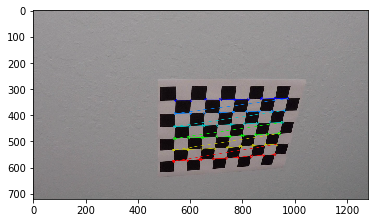

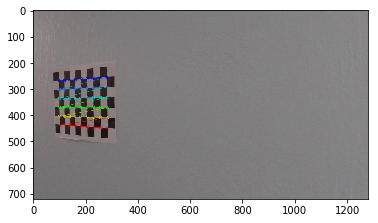

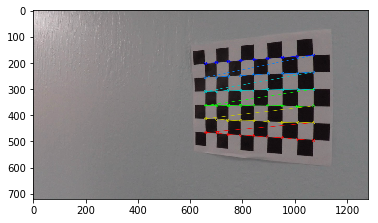

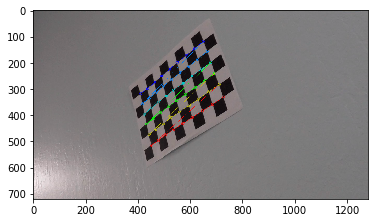

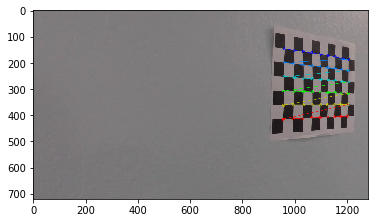

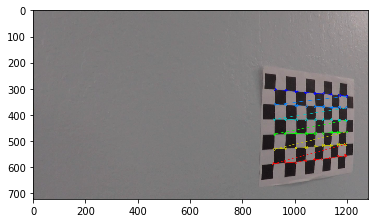

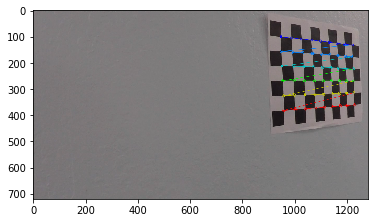

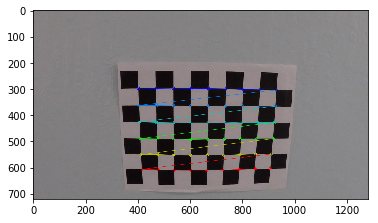

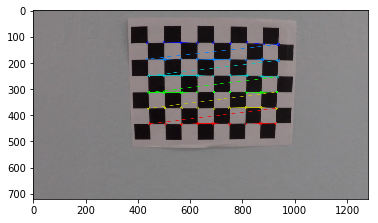

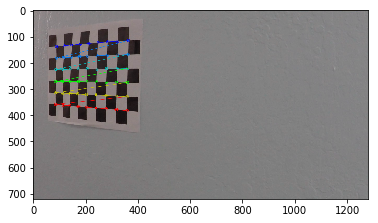

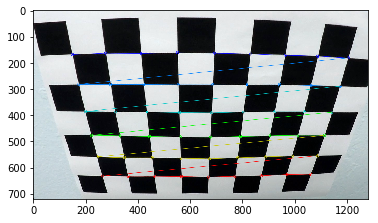

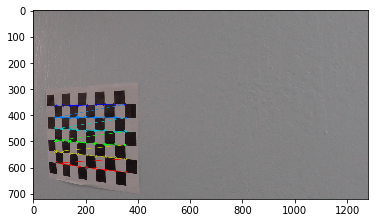

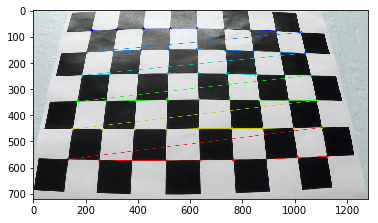

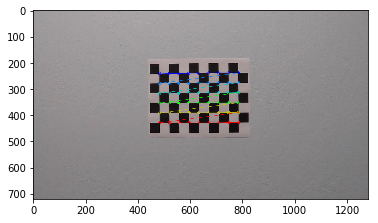

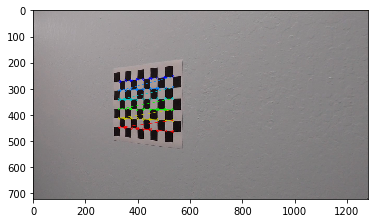

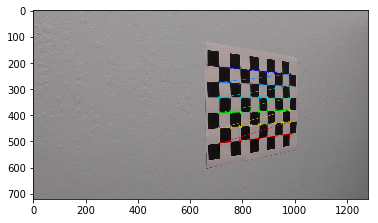

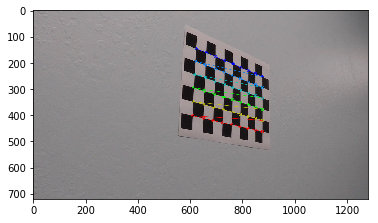

In [17]:
_,_ = get_obj_and_img_points(patterns_fn, display = True)

Obtaining calibration and distortion matrices and save them

In [18]:
try:
    calibration_params = pickle.load(open('calibration_parameters.p', 'rb'))
    print('parameters loaded successfully')
except:
    obj_points, img_points = get_obj_and_img_points(patterns_fn)
    ret, mtx, dist, _, _  = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1],None,None)
    calibration_params = dict([('mtx', mtx), ('dist', dist)])
    pickle.dump(calibration_params, open('calibration_parameters.p', 'wb'))
    print('parameters saved successfully')


parameters loaded successfully


In [19]:
def undistort(image, mtx = calibration_params['mtx'], dist = calibration_params['dist']):
    """simplified undistort function"""
    return cv2.undistort(image, calibration_params['mtx'], calibration_params['dist'], None, calibration_params['mtx'])

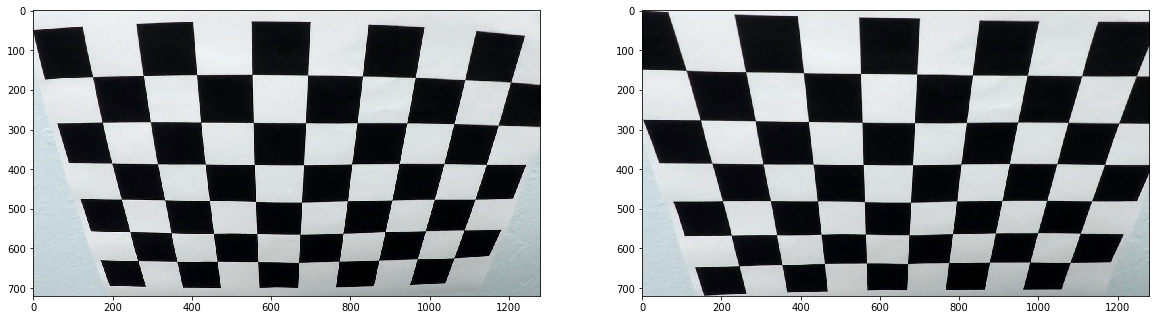

In [20]:
"""example of successful undistortion"""
test_image = cv2.imread(os.path.join(os.getcwd(), patterns_path, 'calibration2.jpg'))
plt.figure(figsize = (20,10))
plt.subplot(121)
plt.imshow(test_image)
undist = undistort(test_image)
plt.subplot(122)
plt.imshow(undist)
plt.show()

In [115]:
class FramePopUp():
    """interactive pop up window to get points of interest in order to perform a correct perspective transformation"""
    def __init__(self, input_img):
        self.root = Tk()
        self.width = input_img.shape[1]
        self.height = input_img.shape[0]
        self.frame = Frame(self.root, bd=2, relief=SUNKEN)
        self.frame.grid_rowconfigure(0, weight=1)
        self.frame.grid_columnconfigure(0, weight=1)
        self.canvas = Canvas(self.frame, bd=0, width = self.width, height = self.height)
        self.canvas.grid(row=0, column=0, sticky=N+S+E+W)
        self.frame.pack(fill=BOTH,expand=1)
        self.img = ImageTk.PhotoImage(Image.fromarray(input_img))
        self.canvas.create_image(0,0,image=self.img,anchor="nw")
        self.canvas.bind("<Button 1>",self.printcoords)
        self.src_points = []
        self.click_count = 0
        mainloop()
        
    def printcoords(self,event):
        self.click_count += 1
        if self.click_count>4:
            self.root.destroy()
            return
        if self.click_count%2 == 1:
            self.canvas.create_line(0, event.y, self.width, event.y)
            self.src_points.append([event.x/self.width , event.y/self.height])
        else:
            self.src_points.append([event.x/self.width, self.src_points[-1][1]])
        self.canvas.create_oval(self.src_points[-1][0]*self.width-2,
                                self.src_points[-1][1]*self.height-2,
                                self.src_points[-1][0]*self.width+2,
                                self.src_points[-1][1]*self.height+2, fill = 'green')
        
    def get_values(self):
        return self.src_points


In [195]:
try:
    src_points = pickle.load(open('source_points.p', 'rb'))
    print('parameters loaded successfully')
except:
    img = undistort(cv2.imread(os.path.join(os.getcwd(), test_images_path, 'straight_lines2.jpg')))
    framePopUp = FramePopUp(img)
    src_points = np.float32(framePopUp.get_values())
    pickle.dump(src_points, open('source_points.p', 'wb'))
    print('parameters saved successfully')


parameters saved successfully


In [196]:
def get_perspective_matrix(input_img, src_points,dst_points):
    h, w = input_img.shape[0], input_img.shape[1]
    src = np.float32([[w,h],
                    [w,h],
                    [w,h],
                    [w,h]])*src_points
    dst = np.float32([[w,h],
                    [w,h],
                    [w,h],
                    [w,h]])*dst_points
    return cv2.getPerspectiveTransform(src,dst), cv2.getPerspectiveTransform(dst,src)
    
def change_to_bird_eye(input_img, M):
    h, w = input_img.shape[0], input_img.shape[1]
    return cv2.warpPerspective(input_img, M, (w, h))


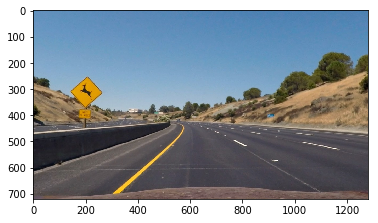

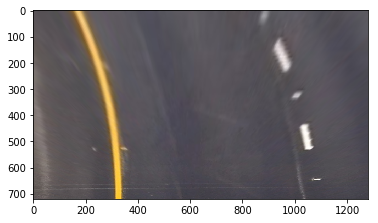

In [197]:
dst_points = np.float32([[0.2,0],[0.8,0],[0.2,1],[0.8,1]])
img = undistort(cv2.imread(os.path.join(os.getcwd(), test_images_path, 'test2.jpg')))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
w, h = img.shape[1], img.shape[0]
M, Minv = get_perspective_matrix(img, src_points,dst_points)
bird_eye_view = change_to_bird_eye(img, M)
plt.figure()
plt.imshow(img)
plt.figure()
plt.imshow(bird_eye_view)
plt.show()

In [205]:
def gaussmf(x,thresh = (0,255), mean = None, sigma = None):
    if mean == None:
        mean = np.mean(thresh)
    if sigma == None:
        sigma = thresh[1]- thresh[0]
    return np.exp(-((x-mean)**2.)/float(sigma)**2.)

def mag_thresh(input_img, sobel_kernel=3, mag_thresh=(0, 255), fuzzy = True):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(input_img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx**2+sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    if fuzzy:
        binary_output = gaussmf(scaled_sobel,mag_thresh).astype(np.float32)
    else:
        binary_output = np.zeros_like(scaled_sobel)
        # 6) Return this mask as your binary_output image

        binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])]  = 1
    return binary_output

def dir_threshold(input_img, sobel_kernel=3, thresh=(0, np.pi/2), mean = None, sigma = None,fuzzy = True):
    gray = cv2.cvtColor(input_img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize = sobel_kernel)
    abs_x = np.absolute(sobelx)
    abs_y = np.absolute(sobely)
    orientation = np.arctan2(abs_y, abs_x)
    if fuzzy:
        binary_output = gaussmf(orientation,thresh, mean, sigma).astype(np.float32)
    else:
        binary_output = np.zeros_like(orientation)
        binary_output[(orientation >= thresh[0]) & (orientation <= thresh[1])] = 1
    return binary_output

def abs_sobel_thresh(input_img, orient='x', thresh=(0,255), sobel_kernel=3, fuzzy = True):
    gray = cv2.cvtColor(input_img, cv2.COLOR_RGB2GRAY)
    abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, orient == 'x', orient == 'y', ksize = sobel_kernel))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    if fuzzy:
        binary_output = gaussmf(scaled_sobel,thresh).astype(np.float32).astype(np.float32)
    else:
        binary_output = np.zeros_like(scaled_sobel)
        binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] =  1
    return binary_output

def hls_select(input_img, thresh=(90, 255), fuzzy = True):
    # 1) Convert to HLS color space
    HLS = cv2.cvtColor(input_img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    s_channel = HLS[:,:,2]
    if fuzzy:
        binary_output = gaussmf(s_channel,thresh).astype(np.float32)
    else:
        binary_output = np.zeros_like(s_channel)
        # 3) Return a binary image of threshold result
        binary_output[(s_channel > thresh[0]) & (s_channel < thresh[1])]  = 1
    return binary_output

def manual_conv_thresh(input_img, top = 0.3, bottom = 0.14, fuzzy = True): 
    gray = cv2.cvtColor(input_img, cv2.COLOR_RGB2GRAY)
    #HLS = cv2.cvtColor(input_img, cv2.COLOR_BGR2HLS)
    high = np.zeros_like(gray)
    low = np.zeros_like(gray)
    weights = np.linspace(top,bottom,gray.shape[0])
    for i, row in enumerate(gray): 
        #val =  min(0.9,max(0.1,-1.64943824e-04*(np.var(HLS[i,:,1]))-3.27541128e-01))
        #high[i,:] = np.convolve(gray[i,:],[-val,-1,-val], 'same')
        #low[i,:] = np.convolve(gray[i,:],[-val,-.1,-val], 'same')
        high[i,:] = np.convolve(gray[i,:],[-weights[i],-1,-weights[i]], 'same')
        low[i,:] = np.convolve(gray[i,:],[-weights[i],-.1,-weights[i]], 'same')
    if fuzzy:
        binary_output = np.maximum(gaussmf(high,(200,255)),gaussmf(low,(0,180))).astype(np.float32)
    else:
        binary_output = np.bitwise_or(high>200,low<180).astype('int')
    return binary_output

def combined_thresholds(input_img, display = False):
    ksize = 5
    gradx = abs_sobel_thresh(input_img, orient='x', sobel_kernel=ksize, thresh=(80, 130))
    grady = abs_sobel_thresh(input_img, orient='y', sobel_kernel=ksize, thresh=(80, 130))
    mag_binary = mag_thresh(input_img, sobel_kernel=ksize, mag_thresh=(40, 255))
    dir_binary = dir_threshold(input_img, sobel_kernel=15, mean = 0, sigma = .75, fuzzy = True)
    neg_dir_binary = dir_threshold(input_img, sobel_kernel=15, mean = 1.57, sigma = 0.2, fuzzy = True)
    conv_binary = manual_conv_thresh(input_img, top = 0.3, bottom = 0.14)
    hls_binary = hls_select(input_img, thresh = (70,255))
    gray = cv2.cvtColor(input_img, cv2.COLOR_RGB2GRAY)
    auto_thresh_binary = cv2.adaptiveThreshold(gray,1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,75,10)
    lab = cv2.cvtColor(input_img, cv2.COLOR_RGB2LAB)
    r_filter = gaussmf(input_img[:,:,0], mean = 220, sigma = 50)
    g_filter = gaussmf(input_img[:,:,1], mean = 180, sigma = 50)
    lab_filter_yellow = gaussmf(lab[:,:,2], mean = 150, sigma = 70)
    lab_filter_white = gaussmf(lab[:,:,0], mean = 240, sigma = 25)
    red_and_green = np.maximum(r_filter, g_filter)
    white_and_yellow = np.maximum( lab_filter_yellow, lab_filter_white)
    colors = np.maximum(red_and_green, white_and_yellow)
    grads = np.maximum(gradx, grady )
    magdir = 0.8* mag_binary + 0.2 * np.minimum(mag_binary, dir_binary)
    convhls = hls_binary + 0.3 * conv_binary
    combined_fuzzy = grads + 0.35 * magdir + 0.3 * convhls + 0.3 * auto_thresh_binary - neg_dir_binary + colors
    combined_fuzzy = combined_fuzzy +0.5*r_filter+0.5*g_filter
    combined_binary = np.zeros_like(dir_binary)
    combined_binary[combined_fuzzy>.8] = 1
    if display:
        plt.figure()
        plt.imshow(gradx, cmap = 'gray')
        plt.figure()
        plt.imshow(grady, cmap = 'gray')
        plt.figure()
        plt.imshow(grads, cmap = 'gray')
        plt.figure()
        plt.imshow(mag_binary, cmap = 'gray')
        plt.figure()
        plt.imshow(dir_binary, cmap = 'gray')
        plt.figure()
        plt.imshow(neg_dir_binary, cmap = 'gray')
        plt.figure()
        plt.imshow(magdir, cmap = 'gray')
        plt.figure()
        plt.imshow(hls_binary, cmap = 'gray')
        plt.figure()
        plt.imshow(conv_binary, cmap = 'gray')
        plt.figure()
        plt.imshow(convhls, cmap = 'gray')
        plt.figure()
        plt.imshow(auto_thresh_binary, cmap = 'gray')
        plt.figure()
        plt.imshow(lab_filter_yellow, cmap = 'gray')
        plt.figure()
        plt.imshow(lab_filter_white, cmap = 'gray')
        plt.figure()
        plt.imshow(r_filter, cmap = 'gray')
        plt.figure()
        plt.imshow(g_filter, cmap = 'gray')
        plt.figure()
        plt.imshow(combined_fuzzy, cmap = 'cool')
        plt.figure()
        plt.imshow(combined_binary, cmap = 'gray')
    return combined_binary, combined_fuzzy


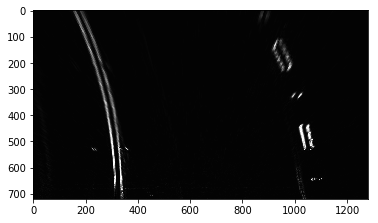

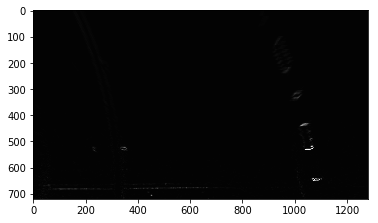

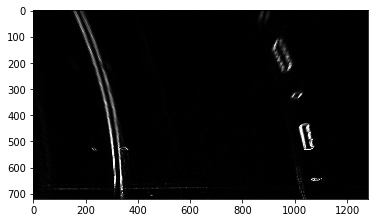

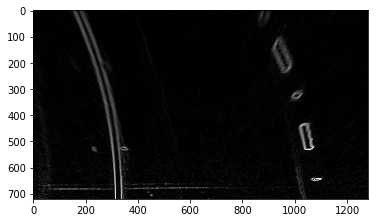

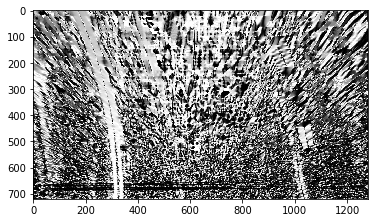

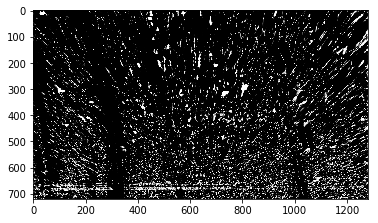

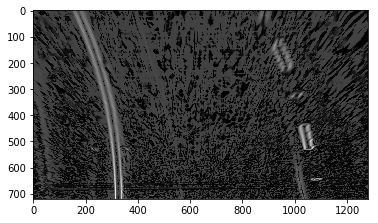

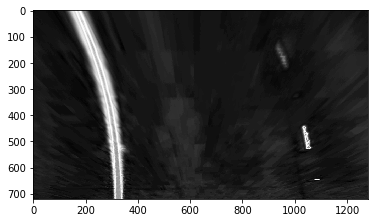

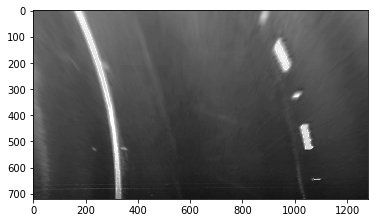

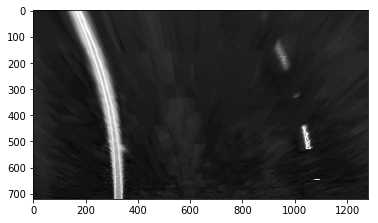

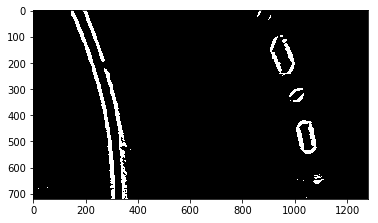

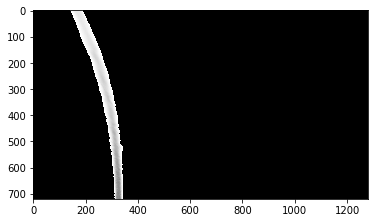

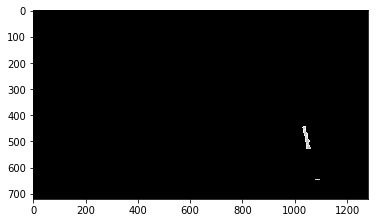

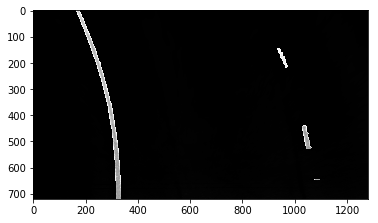

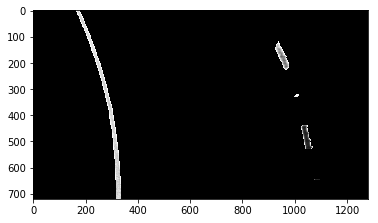

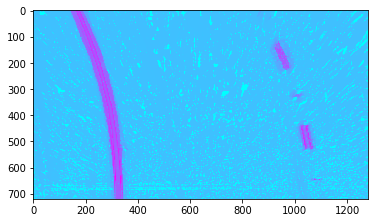

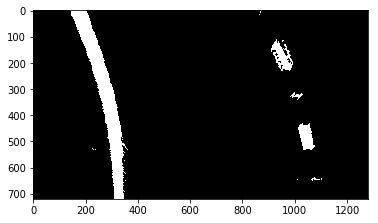

In [206]:
combined, _= combined_thresholds(bird_eye_view, display = True)

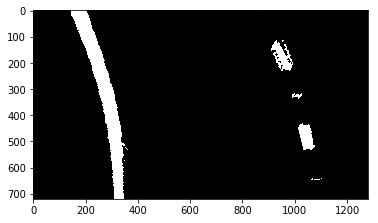

In [207]:
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(combined, cv2.MORPH_OPEN, kernel)
plt.imshow(opening, cmap = 'gray')

In [208]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        self.x_points = None
        self.y_points = None
        
        self.all_coef = deque([], maxlen = 10)
        self.last_fit_coef = None
        
        self.poly = None
        
        self.image = None
        
    def coef_update(self, new_coef):
        self.last_fit_coef = new_coef
        if len(self.all_coef)>0:
            if ~np.any((np.log10(np.abs(self.get_median_coef()- new_coef))>[-1,-1,5])):
                self.all_coef.append(new_coef)
                self.detected = True
            else:
                self.detected = False
        else:
            self.all_coef.append(new_coef)
        self.all_coef.append(new_coef)
        
    def get_median_coef(self):
        return np.median(self.all_coef, axis = 0)

In [209]:
lines = {'left': Line(), 'right':Line()}

In [210]:
def find_lane_lines(binary_image, windows_height = 50, min_width = 50, max_width = 150, display = False):
    if display:
        fig = plt.figure(figsize = (20,10))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122, projection='3d')
        ax1.imshow(binary_image, cmap = 'gray')
    left_windows_width = max_width
    right_windows_width = max_width
    left_mean = 300
    right_mean = 1100
    left_image = np.zeros_like(binary_image)
    right_image = np.zeros_like(binary_image)
    if display:
        sequence = tqdm(range(binary_image.shape[0],0,-windows_height))
    else:
        sequence = range(binary_image.shape[0],0,-windows_height)
    for i in sequence:
        x = np.linspace(0,binary_image.shape[1]-1,binary_image.shape[1],dtype = 'int')
        x_left = x[left_mean-left_windows_width:left_mean+left_windows_width]
        y_left = np.sum(binary_image[i-windows_height:i,left_mean-left_windows_width:left_mean+left_windows_width], axis = 0)
        if display:
            ax1.add_patch(patches.Rectangle((left_mean-left_windows_width,i-windows_height), 2*left_windows_width,windows_height, fill = False,edgecolor="red"))
        if len(y_left)>0:
            if np.max(y_left)>5: 
                left_mean = int(x_left[int(np.median(np.argwhere(y_left==np.max(y_left))))])
                left_windows_width = max(min_width, left_windows_width-50)
            else:
                left_windows_width = min(max_width, left_windows_width+10)
        left_image[i-windows_height:i,left_mean-left_windows_width:left_mean+left_windows_width] = binary_image[i-windows_height:i,left_mean-left_windows_width:left_mean+left_windows_width]    

        x_right = x[right_mean-right_windows_width:right_mean+right_windows_width]
        y_right = np.sum(binary_image[i-windows_height:i,right_mean-right_windows_width:right_mean+right_windows_width], axis = 0)
        if display:
            ax1.add_patch(patches.Rectangle((right_mean-right_windows_width,i-windows_height), 2*right_windows_width,windows_height,fill = False,edgecolor="blue"))
        if len(y_right)>0:
            if np.max(y_right)>5:
                right_mean = int(x_right[int(np.median(np.argwhere(y_right==np.max(y_right))))])
                right_windows_width = max(min_width, right_windows_width-50)
            else:
                right_windows_width = min(max_width, right_windows_width+10)
        right_image[i-windows_height:i,right_mean-right_windows_width:right_mean+right_windows_width] = binary_image[i-windows_height:i,right_mean-right_windows_width:right_mean+right_windows_width]    
        if display:
            ax2.bar(x_left,y_left,i,zdir='y',color = 'r')
            ax2.bar(x_right,y_right,i,zdir='y',color = 'b')
    return left_image, right_image

In [211]:
def find_lane_lines_with_coef(binary_image, fit_coef,margin = 100):
    nonzero = binary_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    lane_inds = ((nonzerox > (fit_coef[0]*(nonzeroy**2) + fit_coef[1]*nonzeroy + fit_coef[2] - margin)) & (nonzerox < (fit_coef[0]*(nonzeroy**2) + fit_coef[1]*nonzeroy + fit_coef[2] + margin))) 
    x = nonzerox[lane_inds]
    y = nonzeroy[lane_inds] 
    return x,y
    

In [212]:
lines['left'].image, lines['right'].image = find_lane_lines(opening, windows_height = 25, min_width = 30)

In [213]:
def fit_lines(input_img, lines):
    if (len(lines['left'].all_coef)<1) or ((len(lines['right'].all_coef)<1)):
        lines['left'].image, lines['right'].image = find_lane_lines(opening, windows_height = 25, min_width = 30)
        [lines['left'].y_points,lines['left'].x_points] = np.nonzero(lines['left'].image)
        [lines['right'].y_points,lines['right'].x_points] = np.nonzero(lines['right'].image)
    else:
        [lines['left'].x_points,lines['left'].y_points] =  find_lane_lines_with_coef(input_img,lines['left'].get_median_coef())
        [lines['right'].x_points,lines['right'].y_points] =  find_lane_lines_with_coef(input_img,lines['right'].get_median_coef())
    if len(lines['left'].x_points)>0:
        lines['left'].coef_update(np.polyfit(lines['left'].y_points,lines['left'].x_points,2))
    if len(lines['right'].x_points)>0:
        lines['right'].coef_update(np.polyfit(lines['right'].y_points,lines['right'].x_points,2))
    lines['left'].poly = np.poly1d(lines['left'].get_median_coef())
    lines['right'].poly = np.poly1d(lines['right'].get_median_coef())
fit_lines(opening, lines)

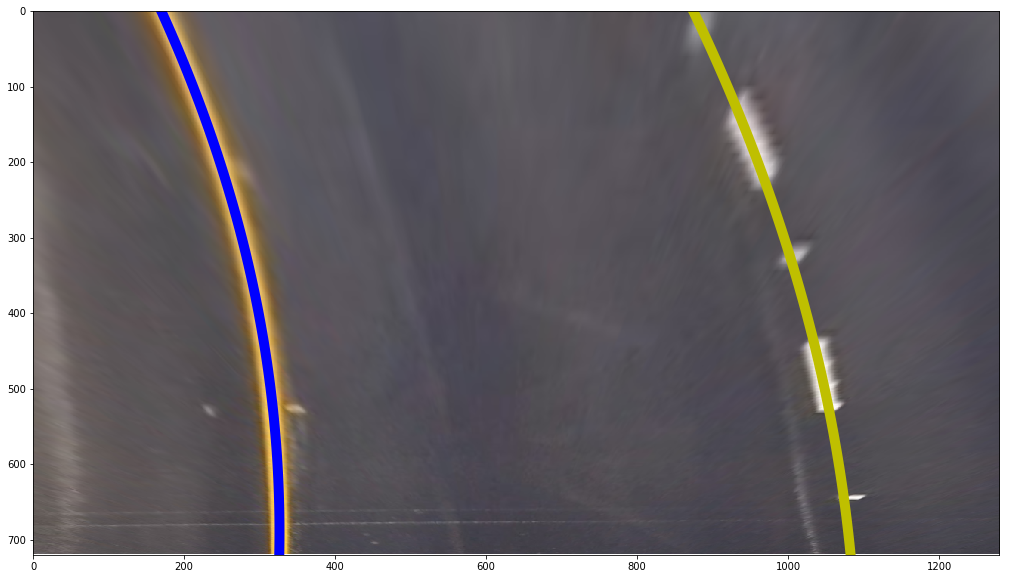

In [214]:
y_points = np.linspace(0,h, 100)

plt.figure(figsize = (20,10))
axes = plt.gca()
axes.set_xlim([0,1280])
axes.set_ylim([720,0])
plt.imshow(bird_eye_view)
plt.plot(lines['left'].poly(y_points),y_points,  linewidth = 10, color = 'b' )
plt.plot(lines['right'].poly(y_points),y_points, linewidth = 10, color = 'y')
plt.show()


In [127]:
def retrive_curvature_and_offset(lines, y_eval, xm_per_pix = 3.7/700,ym_per_pix = 30/720):
    # Fit new polynomials to x,y in world space
    if len(lines['left'].x_points)>0:
        left_fit_cr = np.polyfit(lines['left'].y_points*ym_per_pix,lines['left'].x_points*xm_per_pix, 2)
        lines['left'].radius_of_curvature = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])

    if len(lines['right'].x_points)>0:
        right_fit_cr = np.polyfit(lines['right'].y_points*ym_per_pix,lines['right'].x_points*xm_per_pix, 2)
        lines['right'].radius_of_curvature = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    if (len(lines['left'].x_points)>0) and (len(lines['right'].x_points)>0):
        offset = (img.shape[1]/2-(lines['right'].poly(img.shape[0])+lines['left'].poly(img.shape[0]))/2)*xm_per_pix
    else:
        offset = 0.0
    return lines['left'].radius_of_curvature, lines['right'].radius_of_curvature, offset
left_curverad, right_curverad, offset = retrive_curvature_and_offset(lines,h)
print(left_curverad, right_curverad, offset )

422.2480618 506.27272929 -0.52781482314


In [191]:
def get_virtual_lane(input_image, lines):
    output_image = np.zeros_like(input_image).astype(np.uint8)
    pts_left = np.array([np.transpose(np.vstack([lines['left'].poly(y_points), y_points]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([lines['right'].poly(y_points), y_points])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(output_image, np.int_([pts]), (55,174, 105))
    return cv2.warpPerspective(output_image, Minv, (output_image.shape[1], output_image.shape[0]))

def overlay_text(input_image, left_curverad,right_curverad,offset):
    text1 = 'Curve radius: ' + '{:.5}'.format(np.mean([left_curverad,right_curverad])) + ' m'
    text2 = 'Offset: ' + '{:.5}'.format(offset) + ' m'
    cv2.putText(input_image, text1, (550,625), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (10,25,20),2)
    cv2.putText(input_image, text2, (550,650), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (10,25,20),2)

In [192]:
lines = {'left': Line(), 'right':Line()}
def process_video(frame):
    undist = undistort(frame)
    bird_eye_view = change_to_bird_eye(undist, M)
    combined, combined_fuzzy = combined_thresholds(bird_eye_view)
    small_combined_fuzzy = cv2.resize(combined_fuzzy, (128,72))
    small_combined_binary = cv2.resize(combined, (128,72))
    opening = cv2.morphologyEx(combined, cv2.MORPH_OPEN, kernel)
    fit_lines(opening, lines)
    left_curverad, right_curverad, offset = retrive_curvature_and_offset(lines,h)
    output_image = get_virtual_lane(frame,lines)
    result = cv2.addWeighted(frame, 1, output_image, 0.3, 0)
    overlay_text(result, left_curverad,right_curverad,offset)
    
    result[0:72,0:128] = cv2.cvtColor((255*small_combined_fuzzy).astype('uint8'), cv2.COLOR_GRAY2RGB)
    result[0:72,128:256] = cv2.cvtColor(255*small_combined_binary.astype('uint8'), cv2.COLOR_GRAY2RGB)
    return result
    

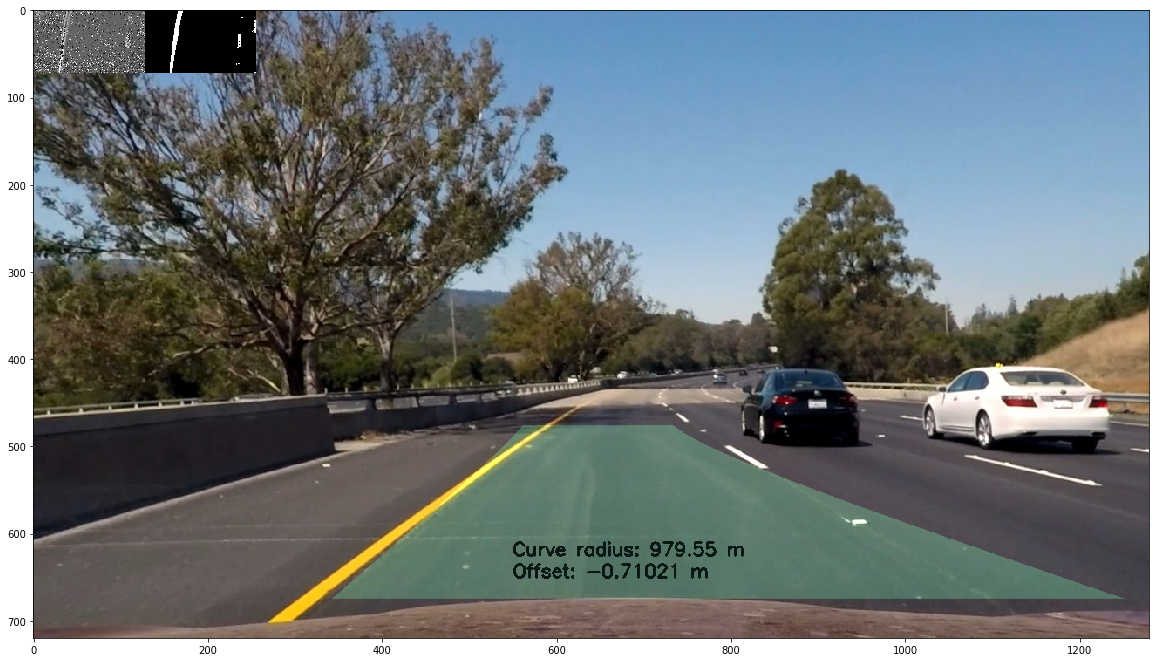

In [193]:
img = undistort(cv2.imread(os.path.join(os.getcwd(), test_images_path, 'test6.jpg')))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,20))
lines = {'left': Line(), 'right':Line()}
plt.imshow(process_video(img))

In [194]:
lines = {'left': Line(), 'right':Line()}
write_output = 'video_output2.mp4'
clip1 = VideoFileClip("project_video.mp4")
write_clip = clip1.fl_image(process_video)
%time write_clip.write_videofile(write_output, audio=False)

[MoviePy] >>>> Building video video_output2.mp4
[MoviePy] Writing video video_output2.mp4


 24%|█████████▏                             | 298/1261 [07:09<24:20,  1.52s/it]

KeyboardInterrupt: 

In [ ]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('video_output2.mp4'))

In [215]:
lines = {'left': Line(), 'right':Line()}
write_output = 'video_output3.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
write_clip = clip1.fl_image(process_video)
%time write_clip.write_videofile(write_output, audio=False)

[MoviePy] >>>> Building video video_output3.mp4
[MoviePy] Writing video video_output3.mp4



100%|████████████████████████████████████████| 485/485 [12:11<00:00,  1.49s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_output3.mp4 

Wall time: 12min 12s


In [216]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('video_output3.mp4'))

In [ ]:
lines = {'left': Line(), 'right':Line()}
write_output = 'video_output.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
write_clip = clip1.fl_image(process_video)
%time write_clip.write_videofile(write_output, audio=False)

In [ ]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('video_output.mp4'))